##  Test Script - Dynamic Validation: Overview
---------------
* This notebook was used for testing features using a dynamic data validation approach. This means that validation data is of the same form as training data with access to  the whole experimental routine. 
* Each feature is tested in isolation and then promising features have been iteratively combined to form different combinations of features. All individual features and combinations of features are tested using 6 different classifiers. 
* Where possible, features have been split into shear and normal forces to provide a comparison of using each component individually and combined. 
* The final classifier and combination of features is identified as those which provide the highest accuracy of object identification using the validation dataset. 


In [1]:
# Importing required packages 
import h5py
import numpy as np 
import matplotlib.pyplot as plt
import math

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC


from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import shuffle
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.preprocessing import StandardScaler

import pandas as pd
from collections import Counter

from sklearn.metrics import plot_confusion_matrix 

from matplotlib.colors import Normalize

# Additional Functions saved in a separate file (To be provided)
import test_functions as func

In [2]:
# Creation of a dictionary to map object names to file locations and object reference 
object_path_dict = {}

object_path_dict['spoolsolder'] = {"file":'/home/elliot/catkin_ws/data/labels/slipDataset_SpoolSolder_tactile.h5',
                                  "object": "SpoolSolder"}
object_path_dict['brush'] = {"file":'/home/elliot/catkin_ws/data/labels/slipDataset_brush_tactile.h5',
                                  "object": "brush"}
object_path_dict['screwdriver'] = {"file":'/home/elliot/catkin_ws/data/labels/slipDataset_screwDriver_tactile.h5',
                                  "object": "screwDriver"}
object_path_dict['teddybear'] = {"file":'/home/elliot/catkin_ws/data/labels/slipDataset_teddyBear_tactile.h5',
                                  "object": "teddyBear"}
object_path_dict['adversarial'] = {"file":'/home/elliot/catkin_ws/data/labels/slipDataset_adversarial_tactile.h5',
                                  "object": "adversarial"}
object_path_dict['tennisball'] = {"file":'/home/elliot/catkin_ws/data/labels/slipDataset_tennisBall_tactile.h5',
                                  "object": "tennisBall"}
object_path_dict['metalbox'] = {"file":'/home/elliot/catkin_ws/data/labels/slipDataset_metalBox_tactile.h5',
                                  "object": "metalBox"}
object_path_dict['legoduplo'] = {"file":'/home/elliot/catkin_ws/data/labels/slipDataset_legoDuplo_tactile.h5',
                                  "object": "legoDuplo"}
object_path_dict['marblenet'] = {"file":'/home/elliot/catkin_ws/data/labels/slipDataset_marbleNet_tactile.h5',
                                  "object": "marbleNet"}

object_path_dict['marker']= {"file":'/home/elliot/catkin_ws/data/labels/slipDataset_marker_tactile.h5',
                                  "object": "marker"}

print(f"{len(object_path_dict)} objects available for comparison")

10 objects available for comparison


In [3]:
# Lists of objects to be used in classification and testing (3 or 10)
object_list = [
#   Use these first 3 for testing on a smaller group of objects
    'tennisBall',
    'metalbox',
    'teddyBear',

#   Remaining objects 
    'brush',
    'screwdriver',
    'adversarial',
    'legoduplo',
    'marblenet',
    'spoolsolder',
    'marker'
]
object_list.sort()
object_list

['adversarial',
 'brush',
 'legoduplo',
 'marblenet',
 'marker',
 'metalbox',
 'screwdriver',
 'spoolsolder',
 'teddyBear',
 'tennisBall']

In [4]:
def extract_features(object_list): 
    """
    A function which extracts all available files for objects given in a provided list. 
    The function returns an array of features, a list of objects and an array of the extracted data for visualisation.
    The array of features returned is representative of the full experimental routine for a single pose and single grasp.
    """
    
    features = []
    labels = []
    x_full_history = []
    y_full_history = []
    z_full_history = [] 
    tactile_sum = []
    
    files_extracted = 0 
    
    # Looping through every object provided in the given list     
    for obj in object_list: 
        
        # Accessing the relevant files for the provided object          
        file_path = object_path_dict[obj.lower()]['file']
        print("\n" , file_path)
        
        # Looping through all possible poses to extract the data         
        for pose in range(1,6):
            
            # A list is kept for any experiments which do not have any data available 
            missing_exp = [] 
            
            # Looping through all possible experiments within each pose 
            for exp in range(1,16):
                
                # Try / Except process is used to handle missing files 
                try: 
                    hf = h5py.File(file_path,'r')        
                    obj_string = object_path_dict[obj.lower()]['object'] + '/Pose' + str(pose) + '/Exp' + str(exp)
                    x_data = np.array(hf[obj_string + '/tactile_data_raw/x'])
                    y_data = np.array(hf[obj_string + '/tactile_data_raw/y'])
                    z_data = np.array(hf[obj_string + '/tactile_data_raw/z'])

                    # Using initial frame as the zero baseline for all readings 
                    x_data = x_data.T
                    y_data = y_data.T
                    z_data = z_data.T

                    x_data = x_data - x_data[0]
                    y_data = y_data - y_data[0]
                    z_data = z_data - z_data[0]

                    x_data = x_data.T
                    y_data = y_data.T
                    z_data = z_data.T

                    tactile_data = np.array(hf[obj_string + '/tactile_changes_label'])
                    hf.close()

                    
                    #                     ----------------------------------
                    """ 
                    Check if any tactile changes are observed. 
                    If no tactile changes are recorded in the file provided it is categorised as missing data.  
                    """

                    tactile_sum.append(np.sum(tactile_data))
                    if np.sum(tactile_data) == 0: 
    #                         print(f"----- No Tactile Changes observed for {obj.lower()} in pose {pose}, experiment {exp}")
                        missing_exp.append(exp)
                        continue
                    
    #                     ----------------------------------
                    """ 
                    Collecting simple distribution metrics for the values across all taxels (min/max)
                    """                                        
                    
                    x_min = np.min(x_data)
                    x_max = np.max(x_data)
                    y_min = np.min(y_data)
                    y_max = np.max(y_data)
                    z_min = np.min(z_data)
                    z_max = np.max(z_data)
                    

    #                     ----------------------------------
                    """ 
                    Collecting simple distribution metrics for the mean values of each taxel (min/max/std)
                    """
                    
                    #  All individual force readings (x/y/z) are averaged across the whole experimental routine       
                    x_data_avg = x_data.mean(axis = 1)
                    x_avg_min = min(x_data_avg)
                    x_avg_max = max(x_data_avg)
                    x_avg_std = np.std(x_data_avg)

                    y_data_avg = y_data.mean(axis = 1)
                    y_avg_min = min(y_data_avg)
                    y_avg_max = max(y_data_avg)
                    y_avg_std = np.std(y_data_avg)

                    z_data_avg = z_data.mean(axis = 1)
                    z_avg_max = max(z_data_avg)
                    z_avg_min = min(z_data_avg)
                    z_avg_std = np.std(z_data_avg)

    #                     ----------------------------------
                    """
                    This section identifies the maximum sum of z values and scans either side to determine a window
                    of the number of frames where best contact has been made    
                    """

                    # index of frame with maximum sum of recorded z values
                    z_total_index = np.argmax(np.sum(z_data,axis=0))

                    # Maximum sum of z values recorded across the experimental routine
                    z_total_max = np.max(np.sum(z_data,axis = 0))

                    # Flag used to determine whether the change in recorded values is within a predefined threshold
                    z_perc_change = True

                    # Counter for the number of frames where the sum of z values is within the given tolerance / threshold
                    i = 0
                    threshold = 0.001

                    # Scanning previous frames to see if the sum of z values is within the given threshold 
                    while z_perc_change and (z_total_index - i)>0: 
                        z_total = np.sum(z_data,axis = 0)[z_total_index - i]
                        z_perc_change = func.percentage_change_tolerance(z_total_max, z_total, t = threshold)
                        if z_perc_change: 
                            i += 1

                    j = 0
                    # Scanning proceeding frames to see if the sum of z values is within the given threshold
                    z_perc_change = True
                    while z_perc_change and (z_total_index + j) < len((np.sum(z_data,axis = 0))): 
                        z_total = np.sum(z_data,axis = 0)[z_total_index + j]
                        z_perc_change = func.percentage_change_tolerance(z_total_max, z_total, t = threshold)
                        if z_perc_change: 
                            j += 1

                    # The total number of frames around the maximum point which are within the given threshold
                    total_frames_at_max = i + j 
                    
    #                     ----------------------------------
                    """
                    This section identifies the maximum sum of x/y/z values for a single frame across all taxels     
                    """
                    x_total_min = np.min(np.sum(x_data,axis = 0)) 
                    x_total_max = np.max(np.sum(x_data,axis = 0)) 
                    y_total_min = np.min(np.sum(y_data,axis = 0))
                    y_total_max = np.max(np.sum(y_data, axis = 0))
                    z_total_max = np.max(np.sum(z_data, axis = 0)) 
                    z_total_min = np.min(np.sum(z_data, axis = 0))  

                    x_sum_std = np.std(np.sum(x_data,axis = 0))
                    y_sum_std = np.std(np.sum(y_data,axis = 0))
                    z_sum_std = np.std(np.sum(z_data,axis = 0))

                    
    #                     ----------------------------------
                    """
                    Identifying the number of taxels engaged at the point of maximum deformation (Z only)   
                    """
                    initial_taxels = z_data[:,0]
                    max_taxels = z_data[:,z_total_index]
                    comparison = max_taxels - initial_taxels
                    # This parameter has been adjusted from 1 up to 200 to identify the optimum value for classification
                    compressed_taxels = np.sum(comparison > 50) 

    #                      ----------------------------------
                    """
                    Calculating the maximum number of consecutive changes/ stable frames as an indicator of flexibility. 
                    Also calculating the total number of recorded changes over the length of the observed experimental routine. 
                    """                   

                    # The total number of consecutive changes recorded during the experimental routine
                    max_changes = func.get_maximum_consecutive_changes(tactile_data)

                    # The total number of consecutive frames with no change in tactile information recorded during the experimental routine 
                    max_stability = func.get_maximum_consecutive_stability(tactile_data)

                    # The proportion of the experimental routine which records a change in tactile information 
                    change_perc = np.sum(tactile_data) / len(tactile_data)
            

                    
    #                      ----------------------------------
                    " Duration gives an indicator of failed attempts, as some objects may fail more easily than others"
                    duration = x_data.shape[1]


                    " Uses duration as an indicator for partially failed attempts"
                    if duration < 200: 
                        partial_contact = 5 
                    elif duration <400: 
                        partial_contact = 4
                    elif duration < 600: 
                        partial_contact = 3
                    elif duration < 800: 
                        partial_contact = 2
                    elif duration < 1000: 
                        partial_contact = 1
                    else: 
                        partial_contact = 0 

                    
           
    #                      ----------------------------------
                    " Features which represent the balance between shear and normal forces to gather information on texture / friction"

                    # The first apporach looks at the maximum of the average values for each individual force
                    force_ratio1 = z_avg_max/ math.sqrt(y_avg_max**2 + x_avg_max**2)


                    # The second approach looks at the difference in values at the same point during the Experimental Procedure 
                    z_change= z_data[:,z_total_index] - z_data[:,0]
                    z_change = np.sum(np.square(z_change))

                    x_change= x_data[:,z_total_index] - x_data[:,0]
                    x_change = np.sum(np.square(x_change))

                    y_change= y_data[:,z_total_index] - y_data[:,0]
                    y_change = np.sum(np.square(y_change))


                    force_ratio2 = z_change / (y_change + x_change)



    #                      ----------------------------------                    
                    """
                    Information about the overall spread of the readings from all taxels (st.dev)
                    """
                    x_all = [x.item() for x in x_data.flatten()]
                    y_all = [y.item() for y in y_data.flatten()]
                    z_all = [z.item() for z in z_data.flatten()]
                    

                    
                    x_full_std = np.std(x_all)
                    y_full_std = np.std(y_all)
                    z_full_std = np.std(z_all)
                   
                    
    #                      ----------------------------------                    

                    """
                    Appending all data for inspection purposes
                    """
                    x_full_history = np.append([x.item() for x in x_data.flatten()],x_full_history)
                    y_full_history = np.append([y.item() for y in y_data.flatten()],y_full_history)
                    z_full_history = np.append([z.item() for z in z_data.flatten()],z_full_history)


    #                      ----------------------------------


                    """
                    Comparison of vectors of shear forces for adjacent taxels
                    """
                    # Transposing data for easier manipulation
                    x_data = x_data.T
                    y_data = y_data.T
                    z_data = z_data.T

                    z_index = np.argmax(z_data[z_total_index,:])

                    # First approach compares maximum taxel to all surrounding taxels

                    # A dictionary is created which records all possible surrounding taxels based on location on the sensor
                    valid_taxels = {}
                    valid_taxels['up'] = True
                    valid_taxels['down'] = True
                    valid_taxels['left'] = True
                    valid_taxels['right'] = True

                    # Check for taxels which are on the edges of the sensor
                    if z_index % 3 == 0: 
                        valid_taxels['left'] = False
                    if z_index in [15,16,17]: 
                        valid_taxels['up'] = False 
                    if z_index in [0,1,2]: 
                        valid_taxels['down'] = False
                    if z_index %3 == 2:
                        valid_taxels['right'] = False
                                        
                   
                    # Lists to be populated with values of x and y forces compared to initial forces 
                    x_vec = []
                    y_vec = []

                    # Values for the central (maximum) taxel
                    x = x_data[z_total_index,z_index]-x_data[0,z_index]
                    y = y_data[z_total_index,z_index]-y_data[0,z_index]
                    x_vec.append(x)
                    y_vec.append(y)

                    # Extracting values for surrounding taxels where possible
                    for i in valid_taxels.keys():
                        if valid_taxels[i] and i == 'up': 
                            x = x_data[z_total_index,z_index +3]-x_data[0,z_index +3]
                            y = y_data[z_total_index,z_index +3]-y_data[0,z_index +3]
                        elif valid_taxels[i] and i == 'down':
                            x = x_data[z_total_index,z_index -3]-x_data[0,z_index -3]
                            y = y_data[z_total_index,z_index -3]-y_data[0,z_index -3]
                        elif valid_taxels[i] and i == 'right':
                            x = x_data[z_total_index,z_index +1]-x_data[0,z_index +1]
                            y = y_data[z_total_index,z_index +1]-y_data[0,z_index +1]
                        elif valid_taxels[i] and i == 'left':
                            x = x_data[z_total_index,z_index -1]-x_data[0,z_index -1]
                            y = y_data[z_total_index,z_index -1]-y_data[0,z_index -1]
                        else: 
                            x = 0
                            y = 0 
                        x_vec.append(x)
                        y_vec.append(y)

                    # Conversion to polar co-ordinates
                    rho, phi = func.cart2pol(x_vec,y_vec)

                    # Creating a matrix which compares each surrounding taxel to the max taxel
                    for i in range(1,len(phi)): 
                        # Vectors are compared using compare_vectors function
                        vec_comparison = func.compare_vectors(phi,0,i)
                        if i == 1: 
                            vec_array = np.array(vec_comparison)
                        else: 
                            vec_array = np.concatenate((vec_array, vec_comparison),axis =0)

                    vec_array = vec_array.reshape(-1,4)
                    vec_array = np.sum(vec_array, axis =0)

                    # Scores are calculated based on the number of taxels surrounding the central taxel which are in the same direction or differing directions as the central taxel
                    xy_corr = 0.25*vec_array[0]
                    if vec_array[1] > 1: 
                        x_corr = 0.25 
                    else: 
                        x_corr = 0 

                    if vec_array[2] > 1: 
                        y_corr = 0.25 
                    else: 
                        y_corr = 0 

                    xy_neg_corr = 0.25*vec_array[3]

    #                      ----------------------------------


                    """
                    View of overall direction of all forces during maximum contact 
                    """
                    # The second approach takes a look at all taxels at the point of maximum contact and simply looks to identify evidence of symmetry or parallel forces in action
                    x_vec = x_data[z_total_index,:].tolist()
                    y_vec = y_data[z_total_index,:].tolist()
                    rho, phi = func.cart2pol(x_vec,y_vec)

                    rho = np.array(rho)
                    phi = np.array(phi)
                    symmetry, parallel = func.compare_all_vectors(phi, rho)




    #                      ----------------------------------
                    """
                    Breaking data down into windows of predetermined length
                    """
            
                    frequency = 180 # Frequency of the tactile sensor used 
                    window_size = 100
                    window_size_t = window_size / frequency # Window size in real time (seconds)
                    total_frames = x_data.shape[0]
                    total_windows = total_frames // window_size + 1
                    
                    #  Checking whether taxels are compressed across the experimental routine                
                    compression_check = z_data > 50
                    
                    average_compression_list = []
                    average_x_total = []
                    average_y_total = []
                    average_z_total = []
                    
                    for i in range(0,total_windows):
                        segment_start = i*window_size
                        segment_end = (i+1)*window_size
                        if segment_end > total_frames: 
                            segment_end = total_frames
                        segment_length = segment_end - segment_start
                        
                        if segment_length == 0: 
                            continue 
                        
                        #  Extracting data within each window.                       
                        x_data_segment = x_data[segment_start:segment_end,:]
                        y_data_segment = y_data[segment_start:segment_end,:]
                        z_data_segment = z_data[segment_start:segment_end,:]
                        compression_segment = compression_check[segment_start:segment_end,:]
                        
                        total_compressed = np.sum(compression_segment)
                        average_compressed = total_compressed/segment_length 
                        average_compression_list.append(average_compressed)
                        
                        x2_total = np.sum(x_data_segment**2)/segment_length
                        y2_total = np.sum(y_data_segment**2)/segment_length
                        z2_total = np.sum(z_data_segment**2)/segment_length 
                        
                        average_x_total.append(x2_total)
                        average_y_total.append(y2_total)
                        average_z_total.append(z2_total)
                        
                    # Extracting features based on compression 
                    max_compression = np.max(average_compression_list)
                    mean_compression = np.mean(average_compression_list)
                    std_compression = np.std(average_compression_list)
                    most_commonly_compressed = max(set(average_compression_list),key = average_compression_list.count)
                    average_compression_list = np.array(average_compression_list)
                    windows_at_most_common = np.sum(average_compression_list == most_commonly_compressed )/len(average_compression_list)
                    
                    # Results for forces are split into three segments 
                    total_segments = len(average_x_total) 
                    
                    # Time in seconds of different motions / size of each window in seconds               
                    # Initial grip and raise is approximately 3 seconds long                     
                    first_period = int(3.0/window_size_t) 
                    
                    # Second phase of raising and rotating the object goes from c. 3 seconds --> 11 seconds                      
                    second_period = int(11.0/window_size_t)

                    # Extracting features based on x/y/z readings in each window                     
                    if second_period >= total_windows: 
                        second_period = total_windows
                        mean_x2_3 = 0
                        mean_y2_3 = 0
                        mean_z2_3 = 0
                        std_x2_3 = 0
                        std_y2_3 = 0
                        std_z2_3 = 0
                    else: 
                        # Features for the "shake" phase of the Experimental Routine                         
                        mean_x2_3 = np.mean(average_x_total[second_period:])
                        mean_y2_3 = np.mean(average_y_total[second_period:])
                        mean_z2_3 = np.mean(average_z_total[second_period:])

                        std_x2_3 = np.std(average_x_total[second_period:])
                        std_y2_3 = np.std(average_y_total[second_period:])
                        std_z2_3 = np.std(average_z_total[second_period:])
                     
                    if first_period >= total_windows: 
                        first_period = total_windows
                        mean_x2_2 = 0
                        mean_y2_2 = 0
                        mean_z2_2 = 0
                        std_x2_2 = 0
                        std_y2_2 = 0
                        std_z2_2 = 0
                    else: 
                        # Features for the "raise and rotate" phase of the Experimental Routine
                        mean_x2_2 = np.mean(average_x_total[first_period:second_period])
                        mean_y2_2 = np.mean(average_y_total[first_period:second_period])
                        mean_z2_2 = np.mean(average_z_total[first_period:second_period])

                        std_x2_2 = np.std(average_x_total[first_period:second_period])
                        std_y2_2 = np.std(average_y_total[first_period:second_period])
                        std_z2_2 = np.std(average_z_total[first_period:second_period])
                   
                    # Features for the "grip and lift" phase of the Experimental routine     
                    mean_x2_1 = np.mean(average_x_total[0:first_period])
                    mean_y2_1 = np.mean(average_y_total[0:first_period])
                    mean_z2_1 = np.mean(average_z_total[0:first_period])

                    std_x2_1 = np.std(average_x_total[0:first_period])
                    std_y2_1 = np.std(average_y_total[0:first_period])
                    std_z2_1 = np.std(average_z_total[0:first_period])

                    
    #                      ----------------------------------
                    """
                    Comparison of taxel readings from initial contact window to following window of the same length.
                    These features are included to give additional attention to the very first contacts made with the object. 
                    """ 
                    frequency = 180 
                    
                    #  The size of the window (in seconds) was determined experimentally 
                    #  Values ranges from 0.1 --> 5 seconds                   
                    window = 0.25 # Time in seconds
                    window_size = int(frequency*window)
                    
                    
                    if window_size > duration:
                        delta_x = 0 
                        delta_y = 0 
                        delta_z = 0 
                        delta_tact = 0 
                    else: 
                        if 2* window_size > duration: 
                            window_end = duration 
                        else: 
                            window_end = 2*window_size
                        initial_contact_x = x_data[0:window_size,:].mean(axis = 0)
                        initial_contact_y = y_data[0:window_size,:].mean(axis = 0)
                        initial_contact_z = z_data[0:window_size,:].mean(axis = 0)
                        initial_contact_tact = np.sum(tactile_data[0:window_size])
                        initial_z_taxel = np.argmax(initial_contact_z)
                        
                        
                        following_contact_x = x_data[window_size: window_end,:].mean(axis = 0)
                        following_contact_y = y_data[window_size: window_end,:].mean(axis = 0)
                        following_contact_z = z_data[window_size: window_end,:].mean(axis = 0)
                        following_contact_tact = np.sum(tactile_data[window_size:window_end])
                        following_z_taxel = np.argmax(following_contact_z)
                        
                        # Extracting features based on the change in taxel readings between initial windows 
                        delta_x = np.sum(initial_contact_x - following_contact_x)
                        delta_y = np.sum(initial_contact_y - following_contact_y)
                        delta_z = np.sum(initial_contact_z - following_contact_z)
                        delta_tact = initial_contact_tact - following_contact_tact
                        delta_max_taxel = initial_z_taxel != following_z_taxel

                        

                    
    
    
    #                      ----------------------------------
                    """
                    Appending desired features as part of a final list
                    """


                    features.append([

                        # Statistical Descriptions of raw data  
                        x_min, x_max,x_full_std,
                        y_min, y_max, y_full_std,
                        z_min, z_max, z_full_std,

                        # Statistical Descriptions of data averaged by each taxel 
                        x_avg_max, x_avg_min, x_avg_std,
                        y_avg_max, y_avg_min, y_avg_std, 
                        z_avg_max, z_avg_min, z_avg_std,

                        # Statistical Descriptions of the sum of forces within each frame 
                        x_total_min, x_total_max,
                        y_total_min, y_total_max,
                        z_total_max, z_total_min,
                        x_sum_std, 
                        y_sum_std, 
                        z_sum_std,

                        # Features based on the length of observed interaction 
                        duration, 
                        partial_contact, 

                        # Features describing the different balances of normal (Z) and shear forces (X/Y)
                        force_ratio1, 
                        force_ratio2, 

                        # Features describing the number of frames where consecutive changes / stability is observed
                        max_changes, 
                        total_frames_at_max, 
                        change_perc, 
                        max_stability, 

                        # Features describing the number of taxels compressed when maximum z-force observed (Static View)
                        compressed_taxels, 

                        # Features describing the direction of the shear forces at point of maximum z-force 
                         xy_corr, 
                         x_corr, 
                         y_corr,
                         xy_neg_corr,
                         symmetry, 
                         parallel,
                        
                        # Dynamic Descriptors - Compression
                         mean_compression, 
                         std_compression,
                         max_compression,
                        most_commonly_compressed,
                        
                        # Dynamic Descriptors - Initial Contact                         
                        delta_x,
                        delta_y,
                        delta_z, 
                        delta_tact,
                        delta_max_taxel,
                        
                        # Dynamic Descriptors - Forces 
                        mean_x2_1, mean_x2_2, mean_x2_3,
                        mean_y2_1, mean_y2_2, mean_y2_3,
                        mean_z2_1, mean_z2_2, mean_z2_3,

                        std_x2_1, std_x2_2, std_x2_3,
                        std_y2_1, std_y2_2, std_y2_3,
                        std_z2_1, std_z2_2, std_z2_3
                                    ])
                    labels.append(obj.lower())
                    files_extracted += 1

                except: 
                    # Handling errors when no objects are found for a given experiment or pose                     
                    missing_exp.append(exp) 
                    # print(f"No data found for '{obj}' in pose{pose:d}")
                    continue
            if len(missing_exp) != 0: 
                print(f"----- No data found for '{obj}' in pose{pose:d} for experiments {missing_exp}")
                
    full_data = [x_full_history, y_full_history, z_full_history, tactile_sum]
    
    # Scaling all features extracted (x' = (x - mean(x)) / std(x))
    scaler = StandardScaler() 
    scaler.fit(features)
    features = scaler.transform(features)
    
    print(f"\nDone! {files_extracted} files extracted")
    return np.array(features), np.array(labels), full_data

In [5]:
#  Single object used to test successful extraction of features 
# single_features, single_label, dummy_data = extract_features(['teddybear'])

In [6]:
# Extraction of all features for given list of objects
features, labels, data = extract_features(object_list)
features.shape


 /home/elliot/catkin_ws/data/labels/slipDataset_adversarial_tactile.h5
----- No data found for 'adversarial' in pose1 for experiments [11, 12, 14]
----- No data found for 'adversarial' in pose2 for experiments [2, 4, 5, 7, 9, 10, 11, 12, 15]
----- No data found for 'adversarial' in pose3 for experiments [2, 6, 11, 13]
----- No data found for 'adversarial' in pose4 for experiments [1, 2, 3, 4, 5, 8, 14, 15]
----- No data found for 'adversarial' in pose5 for experiments [2, 8, 9, 11, 15]

 /home/elliot/catkin_ws/data/labels/slipDataset_brush_tactile.h5
----- No data found for 'brush' in pose1 for experiments [14]
----- No data found for 'brush' in pose3 for experiments [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
----- No data found for 'brush' in pose4 for experiments [1, 2, 3, 7, 15]
----- No data found for 'brush' in pose5 for experiments [1, 2, 3, 4, 8, 9, 11, 13, 15]

 /home/elliot/catkin_ws/data/labels/slipDataset_legoDuplo_tactile.h5
----- No data found for 'legoduplo' in 

(572, 69)

In [7]:
cap_training_samples = False #  Option to limit the number of training / validation samples for all objects

# This was done to test the impact of limiting the number of samples to that of the least represented object.
if cap_training_samples == True:
    
    # Creating a dataframe for all features and objects     
    feature_df = pd.DataFrame(features, columns = [

                            # Statistical Descriptions of raw data  
                            'x_min', 'x_max','x_full_std',
                            'y_min', 'y_max', 'y_full_std',
                            'z_min', 'z_max', 'z_full_std',

                            # Statistical Descriptions of data averaged by each taxel 
                            'x_avg_max', 'x_avg_min', 'x_avg_std',
                            'y_avg_max', 'y_avg_min', 'y_avg_std', 
                            'z_avg_max', 'z_avg_min', 'z_avg_std',

                            # Statistical Descriptions of the sum of forces within each frame 
                            'x_total_min', 'x_total_max',
                            'y_total_min', 'y_total_max',
                            'z_total_max', 'z_total_min',
                            'x_sum_std', 
                            'y_sum_std', 
                            'z_sum_std',

                            # Features based on the length of observed interaction 
                            'duration', 
                            'partial_contact', 

                            # Features describing the different balances of normal (Z) and shear forces (X/Y)
                            'force_ratio1', 
                            'force_ratio2', 

                            # Features describing the number of frames where consecutive changes / stability is observed
                            'max_changes', 
                            'total_frames_at_max', 
                            'change_perc', 
                            'max_stability', 

                            # Features describing the number of taxels compressed when maximum z-force observed 
                            'compressed_taxels', 

                            # Features describing the direction of the shear forces at point of maximum z-force 
                             'xy_corr', 
                             'x_corr', 
                             'y_corr',
                            'xy_neg_corr',
                             'symmetry', 
                             'parallel',

                            # Dynamic Descriptors - Compression
                             'mean_compression', 
                             'std_compression',
                             'max_compression',
                            'most_commonly_compressed',
                            
                            # Dynamic Descriptors - Initial Contact 
                            'delta_x',
                            'delta_y',
                            'delta_z', 
                            'delta_tact',
                            'delta_max_taxel',
                            
                            # Dynamic Descriptors - Forces
                            'mean_x2_1', 'mean_x2_2', 'mean_x2_3',
                            'mean_y2_1', 'mean_y2_2', 'mean_y2_3',
                            'mean_z2_1', 'mean_z2_2', 'mean_z2_3',
                            'std_x2_1', 'std_x2_2', 'std_x2_3',
                            'std_y2_1', 'std_y2_2', 'std_y2_3',
                            'std_z2_1', 'std_z2_2', 'std_z2_3'
        
                                        ])
    feature_df['labels'] = labels

    capped_features = []
    capped_labels = []

    min_length = np.inf
    # Identifying the object with the lowest number of available samples      
    for i in feature_df.labels.unique():
        object_df = feature_df[feature_df['labels']== i]
        length = object_df.labels.count()
        if length < min_length: 
            min_length = length
            min_object = object_df.labels.unique()
    
    #  Limiting all objects to the minimum number of available samples   
    for i in feature_df.labels.unique():
        object_df = feature_df[feature_df['labels']== i]
        object_df = object_df.sort_values(by = 'duration',ascending=False).head(min_length)
        object_labels = object_df['labels'].to_numpy()
        object_df = object_df.drop(columns='labels')
        object_df = object_df.to_numpy()
        if len(capped_features)==0: 
            capped_features = object_df
            capped_labels = object_labels
            
        else: 
            capped_features = np.concatenate((capped_features,object_df))
            capped_labels = np.concatenate((capped_labels, object_labels))

    features = capped_features
    labels = capped_labels

    print(f"{min_length} samples available per object for training and validation.")
    print(f"{min_object[0]} is the object with the fewest samples.")
    


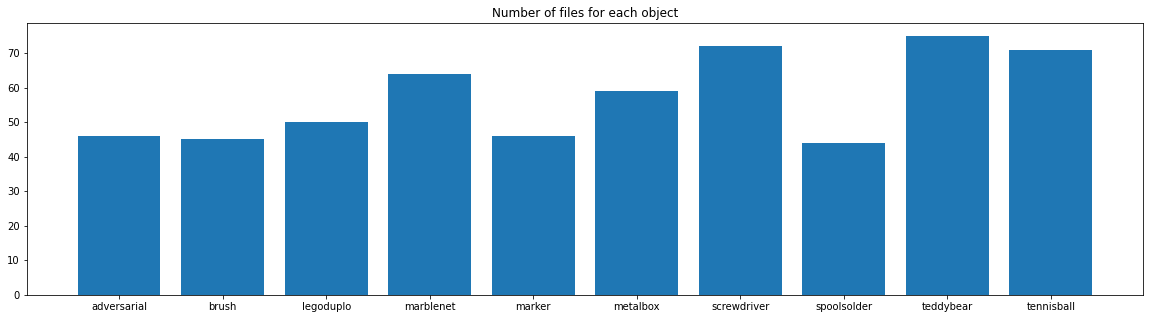

In [8]:
# A plot for showing the number of files extracted for each object 
counts = Counter(labels)
label_names, label_counts = zip(*counts.items())
indexes = np.arange(len(label_names))
fig, ax = plt.subplots(1,1,figsize = (20,5))
ax.bar(label_names,label_counts)
ax.set_title("Number of files for each object")
plt.show()

In [9]:
# A dictionary which maps each named feature to an index, this is used for extracting individual features and subgroups of features 
feature_dict = {    
    # Statistical Descriptions of raw data  
    'x_min':0, 
    'x_max':1, 
    'x_std':2,
    'y_min':3,
    'y_max':4,
    'y_std':5,
    'z_min':6, 
    'z_max':7,
    'z_std':8,

    # Statistical Descriptions of data averaged by each taxel 
    'x_avg_max':9, 
    'x_avg_min':10, 
    'x_avg_std':11,
    'y_avg_max':12, 
    'y_avg_min':13, 
    'y_avg_std':14, 
    'z_avg_max':15,
    'z_avg_min':16, 
    'z_avg_std':17,

    # Statistical Descriptions of the sum of forces within each frame 
    'x_total_min':18, 
    'x_total_max':19,
    'y_total_min':20, 
    'y_total_max':21,
    'z_total_max':22,
    'z_total_min':23,
    'x_sum_std':24,
    'y_sum_std':25,
    'z_sum_std':26,

    # Features based on the length of observed interaction 
    'duration':27, 
    'partial_contact':28, 

    # Features describing the different balances of normal (Z) and shear forces (X/Y)
    'force_ratio1':29, 
    'force_ratio2':30, 

    # Features describing the number of frames where consecutive changes / stability is observed
    'max_changes':31, 
    'total_frames_at_max':32, 
    'change_perc':33, 
    'max_stability': 34, 

    # Features describing the number of taxels compressed when maximum z-force observed 
    'compressed_taxels':35, 

    # Features describing the direction of the shear forces at point of maximum z-force 
     'xy_corr':36, 
     'x_corr':37, 
     'y_corr':38,
     'xy_neg_corr':39,
     'symmetry':40, 
     'parallel':41,
    
    # Dynamic Features - Compression     
    'mean_compression':42, 
    'std_compression':43,
    'max_compression':44,
    'most_commonly_compressed':45,

    # Dynamic Features - Initial Contact     
    'delta_x':46, 
    'delta_y':47,
    'delta_z':48, 
    'delta_tact':49,
    'delta_max_taxel':50,
    
    # Dynamic Features - Forces     
    'mean_x2_1':51,'mean_x2_2':52,'mean_x2_3':53,
    'mean_y2_1':54,'mean_y2_2':55,'mean_y2_3':56,
    'mean_z2_1':57,'mean_z2_2':58,'mean_z2_3':59,
    'std_x2_1':60,'std_x2_2':61,'std_x2_3':62,
    'std_y2_1':63,'std_y2_2':64,'std_y2_3':65,
    'std_z2_1':66,'std_z2_2':67,'std_z2_3':68,
    
}



In [10]:
if True: 
    #  The testing loop which is used to test each feature in isolation to identify those that perform best in classification
    full_results = []

    # Loop through each feature
    for i in range(len(features[0])): 

        # Extract data for a single feature     
        single_feature = features[:,i]

        # Split the data in a stratified way to ensure there are training and test samples available for each object
        # Repeat the split 10 times to get an average performance for each feature
        sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.3)
        sss.get_n_splits(single_feature,labels)
        accuracy_tracker = []
        for train_index, test_index in sss.split(single_feature,labels):
            X_train, X_test = single_feature[train_index], single_feature[test_index]
            y_train, y_test = labels[train_index], labels[test_index]

            X_train = X_train.reshape(-1,1)
            X_test = X_test.reshape(-1,1)


            #  Nearest Neighbour Classifier (k = 1)
            #  -----------------------------------------
            neigh1 = KNeighborsClassifier(n_neighbors = 1)
            neigh1.fit(X_train,y_train)


            #  Nearest Neighbour Classifier (k = 3)
            #  -----------------------------------------
            neigh3 = KNeighborsClassifier(n_neighbors = 3)
            neigh3.fit(X_train,y_train)

            #  Nearest Neighbour Classifier (k = 5)
            #  -----------------------------------------
            neigh5 = KNeighborsClassifier(n_neighbors = 5)
            neigh5.fit(X_train,y_train)

            #  Random Forest Classifier 
            #  -----------------------------------------
            rf_clf = RandomForestClassifier(max_depth = 7)
            rf_clf.fit(X_train,y_train)      

            #  Naive Bayes Classifier 
            #  -----------------------------------------
            gnb_clf = GaussianNB()
            gnb_clf.fit(X_train,y_train)

            #  Linear SVC Classifier
            #  -----------------------------------------
            svc_clf = LinearSVC(max_iter = 2000,dual = False)
            svc_clf.fit(X_train,y_train)


            #  Accuracy of each classifier
            #  -----------------------------------------
            knn1_acc = np.sum(neigh1.predict(X_test)==y_test)/len(y_test)*100
            knn3_acc = np.sum(neigh3.predict(X_test)==y_test)/len(y_test)*100
            knn5_acc = np.sum(neigh5.predict(X_test)==y_test)/len(y_test)*100
            rf_acc = np.sum(rf_clf.predict(X_test)==y_test)/len(y_test)*100
            gnb_acc = np.sum(gnb_clf.predict(X_test)==y_test)/len(y_test)*100
            svc_acc = np.sum(svc_clf.predict(X_test)==y_test)/len(y_test)*100
            accuracy_tracker.append([knn1_acc,knn3_acc,knn5_acc, rf_acc, gnb_acc, svc_acc])

        # Record the name of the feature used to achieve the recorded accuracy     
        for j in feature_dict: 
            if feature_dict[j] ==i: 
                feature_name = j

        accuracy_array = np.array(accuracy_tracker)
        mean_accuracy = np.mean(accuracy_tracker,axis = 0)
        full_results.append(mean_accuracy)

    # Save the results to a file for future reference / use
    path = "classifier_comparison" + str(len(object_list)) + ".txt"
    f = open(path,"w")  
    f.write(f"feature\tknn1\tknn3\tknn5\trf_clf\tgnb\tsvc\tmax\n")
    for i, result in enumerate(full_results): 
        for j in feature_dict: 
            if feature_dict[j] ==i: 
                feature_name = j
        f.write(f"{feature_name}\t")
        f.write(f"{result[0]:.2f}\t{result[1]:.2f}\t{result[2]:.2f}\t{result[3]:.2f}\t{result[4]:.2f}\t{result[5]:.2f}\t{np.max(result):.2f}")
        f.write("\n")
    f.close()

In [11]:
# Loading the data from the saved file to be viewed in a DataFrame
path = "classifier_comparison" + str(len(object_list)) + ".txt"
df = pd.read_csv(path, sep ="\t")
df = df.set_index('feature')

# Set a band to view features with differing classifying powers
band = [30,100]
m1 = (df > band[0]).any(1)
m2 = (df < band[1]).any(1)
df1 = df.loc[m1 & m2]
df = df.sort_values(by = 'max', ascending = False)
df[(df['max'] <band[1]) & (df['max']>band[0])]
pd.set_option('display.max_rows',df.shape[0]+1)
df1

,knn1,knn3,knn5,rf_clf,gnb,svc,max
feature,,,,,,,
z_max,25.41,25.29,28.78,30.87,20.70,26.22,30.87
z_avg_min,23.43,24.13,29.19,31.63,22.44,17.21,31.63
compressed_taxels,17.27,18.49,23.14,31.98,25.47,26.05,31.98
max_compression,25.81,25.81,29.13,32.85,28.90,26.74,32.85
most_commonly_compressed,17.09,18.55,21.40,31.40,25.23,14.30,31.40
mean_z2_2,24.65,27.33,29.83,31.57,22.56,14.53,31.57
mean_z2_3,27.15,27.44,30.41,32.03,27.79,23.02,32.03
std_y2_2,21.34,23.20,28.02,30.17,27.79,27.44,30.17


In [12]:
def create_feature_combinations(category_lists, shear = True, normal = True):
    """
    A function which selects groups of features based on a list of dictionaries as an input. 
    Some features within groups are not considered (and as such are commented out) due to either poor performance 
    during the testing of individual features, or inferior performance compared to a similar feature. 
    """
    all_combinations = []
    for feat_dict in category_lists:
        feature_combinations = []
        # Statistical Descriptions of raw data 
        if feat_dict['raw_taxels']:
            sub_group = []
            if shear: 
                sub_group.extend([
                   'x_min', 
                    'x_max', 
                    'x_std',
                    'y_min',
                    'y_max',
                    'y_std'
                ]
                )
            if normal: 
                sub_group.extend([
                    'z_min', 
                    'z_max',
                    'z_std'
                ])
            feature_combinations.extend(sub_group)


        # Statistical Descriptions of data averaged by each taxel 
        if feat_dict['average_taxels']:
            sub_group =[]
            if shear: 
                sub_group.extend([
                    'x_avg_max', 
                    'x_avg_min', 
#                     'x_avg_std',
                    'y_avg_max', 
                    'y_avg_min', 
#                     'y_avg_std'
                ])
            if normal: 
                sub_group.extend([   
                    'z_avg_max',
                    'z_avg_min', 
#                     'z_avg_std',  
                ])

                
            feature_combinations.extend(sub_group)
             

        # Statistical Descriptions of the sum of forces within each frame 
        if feat_dict['frame_sums']:
            sub_group = []
            if shear: 
                sub_group.extend([
                    'x_total_min', 
                    'x_total_max',
                    'y_total_min', 
                    'y_total_max',
                    'x_sum_std',
                    'y_sum_std',
                ])
            if normal: 
                sub_group.extend([
#                     'z_total_min',
                    'z_total_max',
#                     'z_sum_std',
                ])
            
            feature_combinations.extend(sub_group)



        # Features based on the length of observed interaction 
        if feat_dict['duration']:
            feature_combinations.extend([
                'duration', 
                'partial_contact',  
            ])


        # Features describing the different balances of normal (Z) and shear forces (X/Y)
        if feat_dict['force_ratios']:
            feature_combinations.extend([
                'force_ratio1', 
#                 'force_ratio2',
            ])

        # Features describing the number of frames where consecutive changes / stability is observed
        if feat_dict['stability']:
            feature_combinations.extend([
#                 'max_changes', 
                # 'total_frames_at_max',
                'change_perc', 
#                 'max_stability', 
            ])


        # Features describing the number of taxels compressed when maximum z-force observed 
        if feat_dict['compressed']:
            feature_combinations.extend([
                'compressed_taxels', 
            ])

        # Features describing the direction of the shear forces at point of maximum z-force 
        if feat_dict['shear_directions']:
            feature_combinations.extend([
                'xy_corr', 
                'x_corr', 
                'y_corr',
                'xy_neg_corr',
                 'symmetry', 
                 'parallel',
            ])

        if feat_dict['compression_dynamic']:
            feature_combinations.extend([
#                 'mean_compression', 
#                 'std_compression',
                'max_compression',
#                 'most_commonly_compressed',
            ])
        if feat_dict['grip_lift']:
            sub_group = []
            if shear: 
                sub_group.extend([
                    'mean_x2_1',
                    'mean_y2_1',
#                     'std_x2_1',
#                     'std_y2_1',
                ])
            if normal: 
                sub_group.extend([
#                     'mean_z2_1',
#                     'std_z2_1',
                ])

            feature_combinations.extend(sub_group)
            
        if feat_dict['raise_rotate']:
            sub_group = []
            if shear:
                sub_group.extend([
                    'mean_x2_2',
                    'mean_y2_2',
#                     'std_x2_2',
#                     'std_y2_2',
                ])
            if normal: 
                sub_group.extend([
#                     'mean_z2_2',
#                     'std_z2_2',
                ])
            feature_combinations.extend(sub_group)
            
        if feat_dict['shake']:
            sub_group = []
            if shear: 
                sub_group.extend([
                    'mean_x2_3',
                    'mean_y2_3',
#                     'std_x2_3',
#                     'std_y2_3',
                ])
            if normal: 
                sub_group.extend([
#                     'mean_z2_3',
#                     'std_z2_3',
                ])
            feature_combinations.extend(sub_group)

        if feat_dict['initial_contact']:
            sub_group = []
            if shear: 
                sub_group.extend([
                    'delta_x', 
                    'delta_y',
                ])
            if normal: 
                sub_group.extend([
                    'delta_z',
                    'delta_tact',
#                     'delta_max_taxel'
                ])

            feature_combinations.extend(sub_group)  
    
        all_combinations.append(feature_combinations)
    
    return all_combinations

In [13]:
feature_combinations_list = [
#     # Initial Testing focussed on one group at a time    
    {'raw_taxels' : False, 'frame_sums':  True, 'average_taxels':False, 'force_ratios':False, 
    'shear_directions': False, 'stability': False,  'duration':False, 'compressed':False,
    'compression_dynamic':False, 'grip_lift':False, 'raise_rotate': False, 'shake': False,
    'initial_contact' : False
    },
#     # Promising groups were then combined to improve accuracy further 
    
    {'raw_taxels' : True, 'frame_sums':  True, 'average_taxels':True, 'force_ratios':True, 
    'shear_directions': False, 'stability': True,  'duration':False, 'compressed':False,
    'compression_dynamic':True, 'grip_lift':True, 'raise_rotate': True, 'shake': True,
    'initial_contact' : True
    },
]

feature_combinations = create_feature_combinations(feature_combinations_list, shear = True, normal = True)
feature_combinations

[['x_total_min',
  'x_total_max',
  'y_total_min',
  'y_total_max',
  'x_sum_std',
  'y_sum_std',
  'z_total_max'],
 ['x_min',
  'x_max',
  'x_std',
  'y_min',
  'y_max',
  'y_std',
  'z_min',
  'z_max',
  'z_std',
  'x_avg_max',
  'x_avg_min',
  'y_avg_max',
  'y_avg_min',
  'z_avg_max',
  'z_avg_min',
  'x_total_min',
  'x_total_max',
  'y_total_min',
  'y_total_max',
  'x_sum_std',
  'y_sum_std',
  'z_total_max',
  'force_ratio1',
  'change_perc',
  'max_compression',
  'mean_x2_1',
  'mean_y2_1',
  'mean_x2_2',
  'mean_y2_2',
  'mean_x2_3',
  'mean_y2_3',
  'delta_x',
  'delta_y',
  'delta_z',
  'delta_tact']]

In [14]:
# A dictionary mapping the index of classifiers to their names for labelling purposes
classifier_dict = {
    0:'knn1',
    1:'knn3',
    2:'knn5',
    3:'rf',
    4:'gnb',
    5:'svc'  
}

In [15]:
# This testing loop tests every listed combination of features for all classifiers. 
if True: # Used to avoid running the training loop when not required
    object_results = []
    
    # Initialising all of the classifiers    
    knn1 = KNeighborsClassifier(n_neighbors = 1)
    knn3 = KNeighborsClassifier(n_neighbors = 3)
    knn5 = KNeighborsClassifier(n_neighbors = 5)
    rf = RandomForestClassifier(max_depth = 7)
    gnb = GaussianNB()
    svc = LinearSVC(max_iter = 2000,dual = False)

    classifiers_list = [knn1,knn3,knn5,rf,gnb,svc]
    
    # Looping through all classifiers     
    for clf in classifiers_list:
        
        #Looping through all feature combinations
        for i in feature_combinations: 
            object_tracker = []
            
            # Selecting a subset of features from all extracted features
            feature_subset = func.select_desired_features(features,i,feature_dict)
            
            # Splitting the data into training and validation splits randomly 10 times 
            sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.3)
            sss.get_n_splits(feature_subset,labels)
            accuracy_tracker = []
            for train_index, test_index in sss.split(feature_subset,labels):
                X_train, X_test = feature_subset[train_index], feature_subset[test_index]
                y_train, y_test = labels[train_index], labels[test_index]
                # print(X_train.shape, X_test.shape)

                # Fitting the classifier
                clf.fit(X_train,y_train)
                
                # Calculating and saving the accuracy
                accuracy = np.sum(clf.predict(X_test)==y_test)/len(y_test)*100
                accuracy_tracker.append(accuracy)

                # Recording the accuracy for each individual object
                for obj in object_list:
                    obj = obj.lower()
                    obj_acc = np.sum(clf.predict(X_test[np.where(y_test == obj)])==y_test[np.where(y_test == obj)])/len(y_test[np.where(y_test == obj)])
                    object_tracker.append(obj_acc)
            
            # Recording the results and getting the average accuracy
            object_tracker = np.array(object_tracker)
            object_tracker = object_tracker.reshape(-1,len(object_list))
            mean_accuracy = np.mean(accuracy_tracker)
            object_mean = np.mean(object_tracker, axis = 0)*100
            object_results.append(object_mean)
    
    # Saving the accuracy for each object to a file for future reference
    object_array = np.array(object_results)
    object_array = object_array.reshape(-1,len(feature_combinations),len(object_list))
    print(object_array.shape)
    path = "feature_combinations_accuracy_multi_clf_" + str(len(object_list))+".txt"
    print(f"Writing to path ''{path}''")
    f = open(path,"w")
    for i in range(len(object_list)):
        f.write(f"{object_list[i]}\t")
    f.write(f"AVG\tclf\tFeatures\n")
    for i, results in enumerate(object_array):
        for j,result in enumerate(results):
            for k in range(len(result)): 
                f.write(f"{result[k]:.2f}\t")
            f.write(f"{np.mean(result):.2f}\t{classifier_dict[i]}\t{feature_combinations[j]}")
            f.write("\n")
    f.close()

(6, 2, 10)
Writing to path ''feature_combinations_accuracy_multi_clf_10.txt''


In [16]:
# Viewing the top performing combinations of features and classifiers based on mean validation accuracy 
path = "feature_combinations_accuracy_multi_clf_" + str(len(object_list))+".txt"
pd.set_option('display.max_colwidth',None)
df3 = pd.read_csv(path, sep ="\t")
df3 = df3.sort_values(by=['AVG'], ascending = False).head(20)
df3

,adversarial,brush,legoduplo,marblenet,marker,metalbox,screwdriver,spoolsolder,teddyBear,tennisBall,AVG,clf,Features
7,43.57,74.62,54.00,63.16,90.00,76.11,83.18,53.08,92.61,89.52,71.98,rf,"['x_min', 'x_max', 'x_std', 'y_min', 'y_max', 'y_std', 'z_min', 'z_max', 'z_std', 'x_avg_max', 'x_avg_min', 'y_avg_max', 'y_avg_min', 'z_avg_max', 'z_avg_min', 'x_total_min', 'x_total_max', 'y_total_min', 'y_total_max', 'x_sum_std', 'y_sum_std', 'z_total_max', 'force_ratio1', 'change_perc', 'max_compression', 'mean_x2_1', 'mean_y2_1', 'mean_x2_2', 'mean_y2_2', 'mean_x2_3', 'mean_y2_3', 'delta_x', 'delta_y', 'delta_z', 'delta_tact']"
1,46.43,69.23,62.67,45.26,92.14,70.00,68.18,57.69,88.70,89.05,68.93,knn1,"['x_min', 'x_max', 'x_std', 'y_min', 'y_max', 'y_std', 'z_min', 'z_max', 'z_std', 'x_avg_max', 'x_avg_min', 'y_avg_max', 'y_avg_min', 'z_avg_max', 'z_avg_min', 'x_total_min', 'x_total_max', 'y_total_min', 'y_total_max', 'x_sum_std', 'y_sum_std', 'z_total_max', 'force_ratio1', 'change_perc', 'max_compression', 'mean_x2_1', 'mean_y2_1', 'mean_x2_2', 'mean_y2_2', 'mean_x2_3', 'mean_y2_3', 'delta_x', 'delta_y', 'delta_z', 'delta_tact']"
11,35.00,70.77,47.33,58.42,92.86,74.44,71.36,53.85,93.91,86.19,68.41,svc,"['x_min', 'x_max', 'x_std', 'y_min', 'y_max', 'y_std', 'z_min', 'z_max', 'z_std', 'x_avg_max', 'x_avg_min', 'y_avg_max', 'y_avg_min', 'z_avg_max', 'z_avg_min', 'x_total_min', 'x_total_max', 'y_total_min', 'y_total_max', 'x_sum_std', 'y_sum_std', 'z_total_max', 'force_ratio1', 'change_perc', 'max_compression', 'mean_x2_1', 'mean_y2_1', 'mean_x2_2', 'mean_y2_2', 'mean_x2_3', 'mean_y2_3', 'delta_x', 'delta_y', 'delta_z', 'delta_tact']"
3,52.14,76.92,58.00,46.84,87.86,66.67,60.45,53.08,78.70,80.48,66.11,knn3,"['x_min', 'x_max', 'x_std', 'y_min', 'y_max', 'y_std', 'z_min', 'z_max', 'z_std', 'x_avg_max', 'x_avg_min', 'y_avg_max', 'y_avg_min', 'z_avg_max', 'z_avg_min', 'x_total_min', 'x_total_max', 'y_total_min', 'y_total_max', 'x_sum_std', 'y_sum_std', 'z_total_max', 'force_ratio1', 'change_perc', 'max_compression', 'mean_x2_1', 'mean_y2_1', 'mean_x2_2', 'mean_y2_2', 'mean_x2_3', 'mean_y2_3', 'delta_x', 'delta_y', 'delta_z', 'delta_tact']"
5,45.00,68.46,60.00,48.42,87.14,67.78,59.55,54.62,84.78,82.86,65.86,knn5,"['x_min', 'x_max', 'x_std', 'y_min', 'y_max', 'y_std', 'z_min', 'z_max', 'z_std', 'x_avg_max', 'x_avg_min', 'y_avg_max', 'y_avg_min', 'z_avg_max', 'z_avg_min', 'x_total_min', 'x_total_max', 'y_total_min', 'y_total_max', 'x_sum_std', 'y_sum_std', 'z_total_max', 'force_ratio1', 'change_perc', 'max_compression', 'mean_x2_1', 'mean_y2_1', 'mean_x2_2', 'mean_y2_2', 'mean_x2_3', 'mean_y2_3', 'delta_x', 'delta_y', 'delta_z', 'delta_tact']"
0,40.71,36.15,58.67,40.00,75.00,70.00,53.64,43.08,74.35,77.62,56.92,knn1,"['x_total_min', 'x_total_max', 'y_total_min', 'y_total_max', 'x_sum_std', 'y_sum_std', 'z_total_max']"
9,18.57,71.54,48.00,40.00,82.14,53.89,49.09,43.08,69.13,82.86,55.83,gnb,"['x_min', 'x_max', 'x_std', 'y_min', 'y_max', 'y_std', 'z_min', 'z_max', 'z_std', 'x_avg_max', 'x_avg_min', 'y_avg_max', 'y_avg_min', 'z_avg_max', 'z_avg_min', 'x_total_min', 'x_total_max', 'y_total_min', 'y_total_max', 'x_sum_std', 'y_sum_std', 'z_total_max', 'force_ratio1', 'change_perc', 'max_compression', 'mean_x2_1', 'mean_y2_1', 'mean_x2_2', 'mean_y2_2', 'mean_x2_3', 'mean_y2_3', 'delta_x', 'delta_y', 'delta_z', 'delta_tact']"
4,47.14,38.46,49.33,45.26,77.86,53.89,53.64,19.23,75.22,78.10,53.81,knn5,"['x_total_min', 'x_total_max', 'y_total_min', 'y_total_max', 'x_sum_std', 'y_sum_std', 'z_total_max']"
2,51.43,41.54,57.33,39.47,73.57,57.22,46.36,18.46,74.78,72.86,53.30,knn3,"['x_total_min', 'x_total_max', 'y_total_min', 'y_total_max', 'x_sum_std', 'y_sum_std', 'z_total_max']"
6,31.43,16.15,45.33,47.37,78.57,55.00,69.55,21.54,78.26,86.67,52.99,rf,"['x_total_min', 'x_total_max', 'y_total_min', 'y_total_max', 'x_sum_std', 'y_sum_std', 'z_total_max']"


In [17]:
# Extracting the best combination of features and classifier 
best_features = df3 ['Features'].tolist()[0]
best_features = best_features.replace("'",'')
best_features = best_features[1:-1].split(", ")

best_clf = df3['clf'].tolist()[0]
print(f"Best CLF: {best_clf}")
print(f"Best Features: {best_features}" )

Best CLF: rf
Best Features: ['x_min', 'x_max', 'x_std', 'y_min', 'y_max', 'y_std', 'z_min', 'z_max', 'z_std', 'x_avg_max', 'x_avg_min', 'y_avg_max', 'y_avg_min', 'z_avg_max', 'z_avg_min', 'x_total_min', 'x_total_max', 'y_total_min', 'y_total_max', 'x_sum_std', 'y_sum_std', 'z_total_max', 'force_ratio1', 'change_perc', 'max_compression', 'mean_x2_1', 'mean_y2_1', 'mean_x2_2', 'mean_y2_2', 'mean_x2_3', 'mean_y2_3', 'delta_x', 'delta_y', 'delta_z', 'delta_tact']


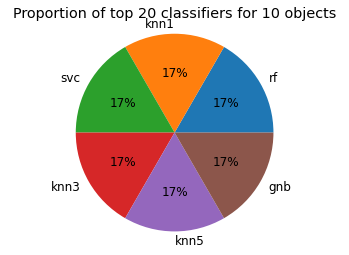

{'rf': 71.98, 'knn1': 68.93, 'knn3': 66.11, 'knn5': 65.86, 'gnb': 55.83, 'svc': 68.41}


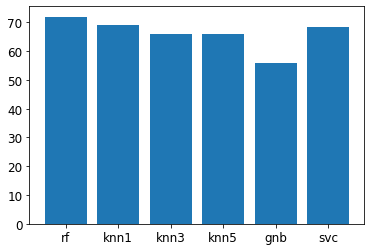

In [27]:
# Plotting a pie chart of which classifiers make up the top 20 performing combinations of features
df4 = pd.read_csv(path, sep ="\t")
df4 = df4.sort_values(by=['AVG'], ascending = False).head(20)
top_classifiers = Counter(df4['clf'])

pie_labels = []
pie_values = []
for a,b in top_classifiers.items(): 
    pie_labels.append(a)
    pie_values.append(b)
    
plt.pie(pie_values, labels = pie_labels, autopct = '%1.f%%')
plt.axis('equal')
plt.title(f'Proportion of top 20 classifiers for {len(object_list)} objects')
plt.show()

df5 = pd.read_csv(path, sep ="\t")
df5 = df5.sort_values(by=['AVG'], ascending = False)


# Calculating, plotting and printing the highest accuracy achieved by each classifier 
classifiers = ['rf','knn1','knn3','knn5','gnb','svc']

classifier_accuracy = {}
for classifier in classifiers: 
    dataframe = df5[df5['clf']==classifier]
    highest_accuracy = dataframe['AVG'].tolist()[0]
    classifier_accuracy[classifier] = highest_accuracy
    
keys = classifier_accuracy.keys() 
values = classifier_accuracy.values()

plt.bar(keys,values)
print(classifier_accuracy)

In [28]:
# Extracting the best features based on validation performance 
feature_subset = func.select_desired_features(features,best_features,feature_dict)

sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.3)
sss.get_n_splits(feature_subset,labels)

# Creating a single split of the data to be used in confusion matrix visualisations
for train_index, test_index in sss.split(feature_subset,labels):
    X_train, X_test = feature_subset[train_index], feature_subset[test_index]
    y_train, y_test = labels[train_index], labels[test_index]


# Selecting the best classifier 
if best_clf == 'rf':
    clf = RandomForestClassifier(max_depth = 7)
elif best_clf == 'knn1':
    clf = KNeighborsClassifier(n_neighbors = 1)
elif best_clf == 'knn3':
    clf = KNeighborsClassifier(n_neighbors = 3)
elif best_clf == 'knn5':
    clf = KNeighborsClassifier(n_neighbors = 5)
elif best_clf == 'gnb':
    clf = GaussianNB()
elif best_clf == 'svc':
    clf = LinearSVC(max_iter = 2000,dual = False)

# Training the classifier
clf.fit(X_train,y_train)
    
y_hat = clf.predict(X_test)
best_clf

'rf'

70.3% accurately identified


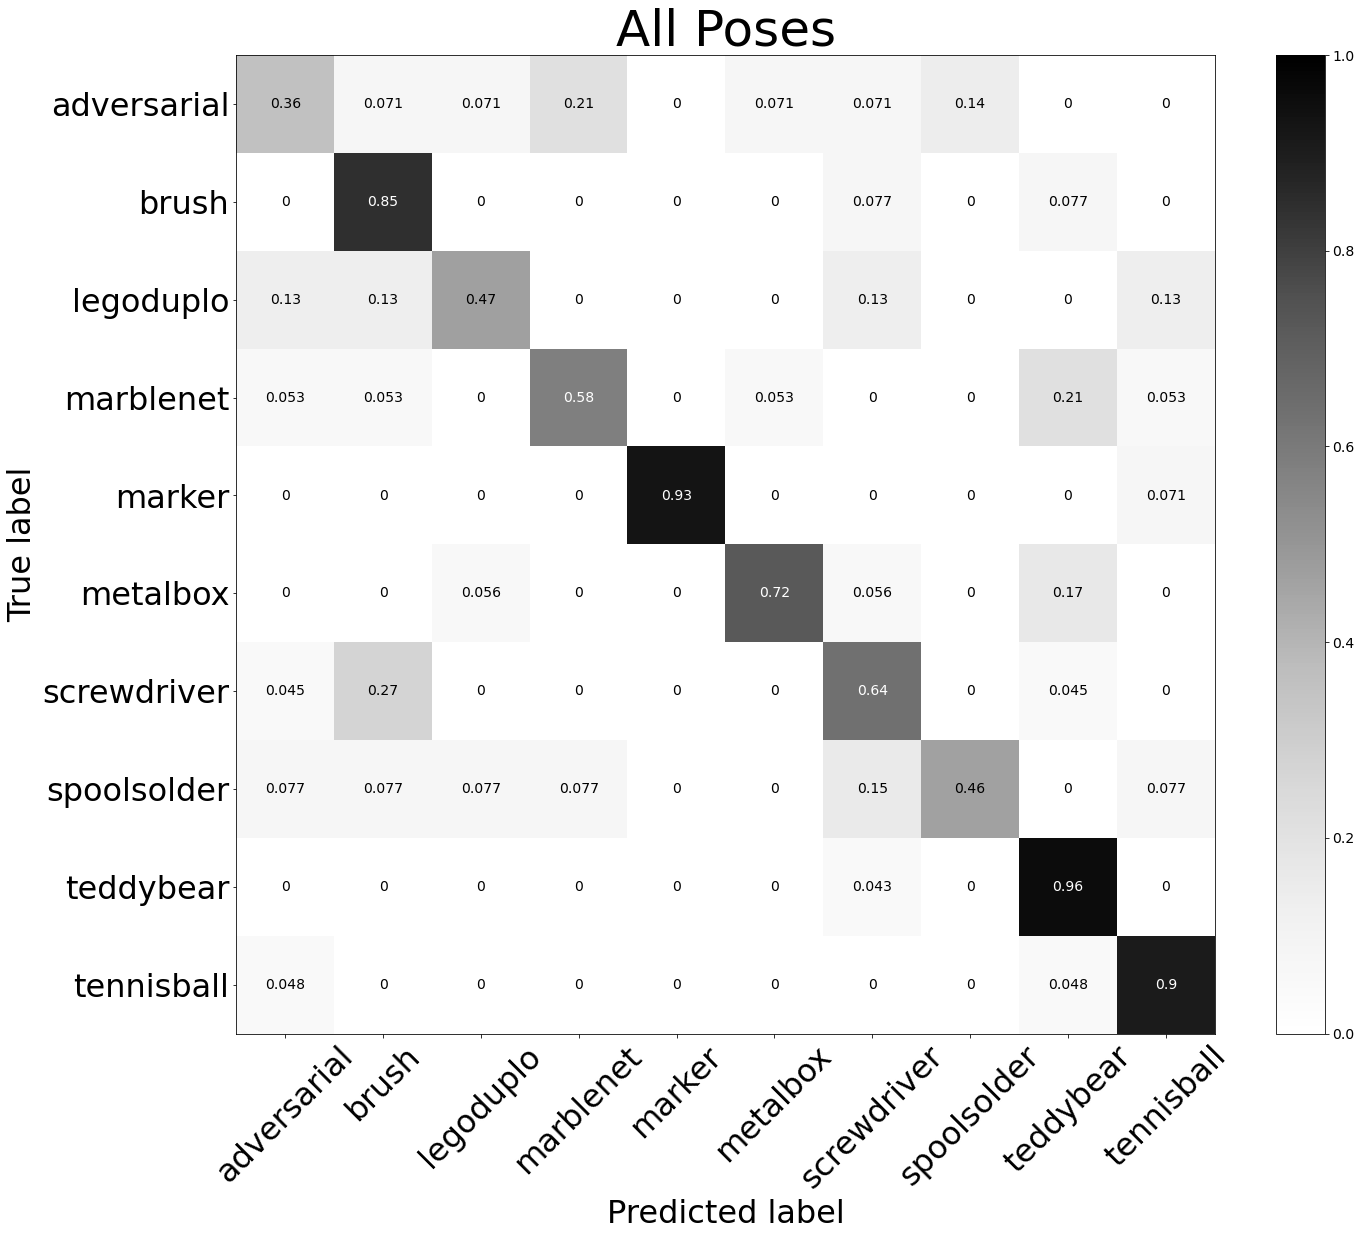

In [34]:
# Plotting the confusion matrix obtained using the best features and classifier combination
plt.rcParams.update({'font.size':32})
fig, ax = plt.subplots(figsize = (22,18))
plt.rcParams.update({'font.size':14})
print(f"{np.sum(y_hat==y_test)/len(y_test)*100:.1f}% accurately identified")
plot_confusion_matrix(clf,X_test, y_test, ax = ax, cmap = 'Greys', normalize = 'true',xticks_rotation = 45)
ax.images[0].set_norm(Normalize(vmin = 0, vmax = 1))
clf
plt.title("All Poses",fontsize=50)
plt.savefig("CM_All.png")

70.3% accurately identified


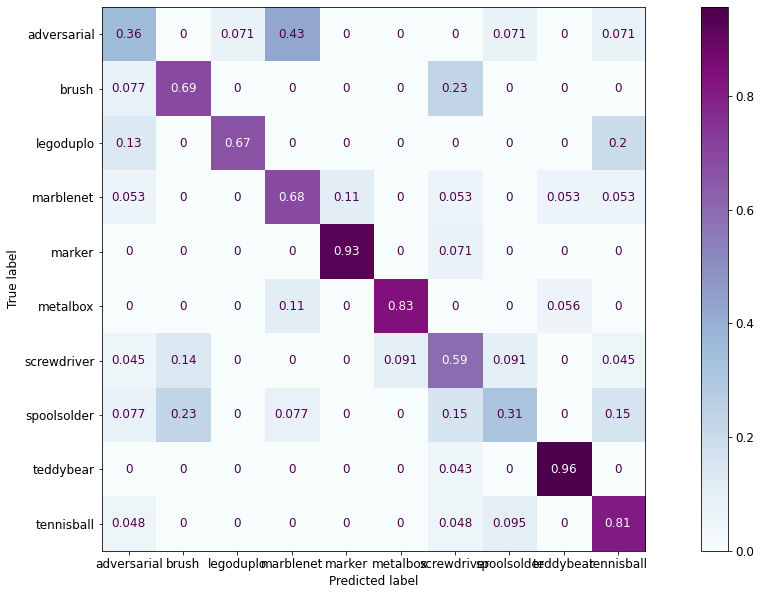

In [26]:
# An additional option to plot the best features using select K-best and a RF-classifier for comparison purposes
if True:   
    sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.3)
    sss.get_n_splits(features,labels)


    for train_index, test_index in sss.split(features,labels):
    #     print(f"X train: {train_index},\n X test: {test_index}")
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
    
    # Select K-best features
    selector = SelectKBest(f_classif, k=20)
    selector.fit(X_train, y_train)
    X_train = selector.transform(X_train)
    X_test = selector.transform(X_test)
    
    # Using a RF classifier 
    clf = RandomForestClassifier(max_depth = 7)
    clf.fit(X_train,y_train)
    y_hat = clf.predict(X_test)

    fig, ax1 = plt.subplots(figsize = (20,10))
    print(f"{np.sum(y_hat==y_test)/len(y_test)*100:.1f}% accurately identified")
    cm = plot_confusion_matrix(clf,X_test, y_test, ax = ax1, cmap = 'BuPu', normalize = 'true')
    plt.show()
    

In [22]:
# Comparing Results achieved using combinations of features for 3 and 10 objects
path = "feature_combinations_accuracy_multi_clf_3.txt"
pd.set_option('display.max_colwidth',None)
df4 = pd.read_csv(path, sep ="\t")
df4 = df4.sort_values(by=['AVG'], ascending = False).head(5)
df4

,metalbox,teddyBear,tennisBall,AVG,clf,Features
3,85.00,95.65,96.19,92.28,rf,"['x_min', 'x_max', 'x_std', 'y_min', 'y_max', 'y_std', 'z_min', 'z_max', 'z_std', 'x_avg_max', 'x_avg_min', 'y_avg_max', 'y_avg_min', 'z_avg_max', 'z_avg_min', 'x_total_min', 'x_total_max', 'y_total_min', 'y_total_max', 'x_sum_std', 'y_sum_std', 'z_total_max', 'force_ratio1', 'change_perc', 'max_compression', 'mean_x2_1', 'mean_y2_1', 'mean_x2_2', 'mean_y2_2', 'mean_x2_3', 'mean_y2_3', 'delta_x', 'delta_y', 'delta_z', 'delta_tact']"
5,83.33,97.39,92.38,91.04,svc,"['x_min', 'x_max', 'x_std', 'y_min', 'y_max', 'y_std', 'z_min', 'z_max', 'z_std', 'x_avg_max', 'x_avg_min', 'y_avg_max', 'y_avg_min', 'z_avg_max', 'z_avg_min', 'x_total_min', 'x_total_max', 'y_total_min', 'y_total_max', 'x_sum_std', 'y_sum_std', 'z_total_max', 'force_ratio1', 'change_perc', 'max_compression', 'mean_x2_1', 'mean_y2_1', 'mean_x2_2', 'mean_y2_2', 'mean_x2_3', 'mean_y2_3', 'delta_x', 'delta_y', 'delta_z', 'delta_tact']"
4,85.56,90.87,91.43,89.28,gnb,"['x_min', 'x_max', 'x_std', 'y_min', 'y_max', 'y_std', 'z_min', 'z_max', 'z_std', 'x_avg_max', 'x_avg_min', 'y_avg_max', 'y_avg_min', 'z_avg_max', 'z_avg_min', 'x_total_min', 'x_total_max', 'y_total_min', 'y_total_max', 'x_sum_std', 'y_sum_std', 'z_total_max', 'force_ratio1', 'change_perc', 'max_compression', 'mean_x2_1', 'mean_y2_1', 'mean_x2_2', 'mean_y2_2', 'mean_x2_3', 'mean_y2_3', 'delta_x', 'delta_y', 'delta_z', 'delta_tact']"
2,78.33,94.78,93.81,88.98,knn5,"['x_min', 'x_max', 'x_std', 'y_min', 'y_max', 'y_std', 'z_min', 'z_max', 'z_std', 'x_avg_max', 'x_avg_min', 'y_avg_max', 'y_avg_min', 'z_avg_max', 'z_avg_min', 'x_total_min', 'x_total_max', 'y_total_min', 'y_total_max', 'x_sum_std', 'y_sum_std', 'z_total_max', 'force_ratio1', 'change_perc', 'max_compression', 'mean_x2_1', 'mean_y2_1', 'mean_x2_2', 'mean_y2_2', 'mean_x2_3', 'mean_y2_3', 'delta_x', 'delta_y', 'delta_z', 'delta_tact']"
0,81.67,88.70,93.33,87.90,knn1,"['x_min', 'x_max', 'x_std', 'y_min', 'y_max', 'y_std', 'z_min', 'z_max', 'z_std', 'x_avg_max', 'x_avg_min', 'y_avg_max', 'y_avg_min', 'z_avg_max', 'z_avg_min', 'x_total_min', 'x_total_max', 'y_total_min', 'y_total_max', 'x_sum_std', 'y_sum_std', 'z_total_max', 'force_ratio1', 'change_perc', 'max_compression', 'mean_x2_1', 'mean_y2_1', 'mean_x2_2', 'mean_y2_2', 'mean_x2_3', 'mean_y2_3', 'delta_x', 'delta_y', 'delta_z', 'delta_tact']"


In [23]:
# Comparing Results achieved using combinations of features for 3 and 10 objects
path = "feature_combinations_accuracy_multi_clf_10.txt"
pd.set_option('display.max_colwidth',None)
df5 = pd.read_csv( path, sep ="\t")
df5 = df5.sort_values(by=['AVG'], ascending = False).head(5)
df5

,adversarial,brush,legoduplo,marblenet,marker,metalbox,screwdriver,spoolsolder,teddyBear,tennisBall,AVG,clf,Features
7,43.57,74.62,54.00,63.16,90.00,76.11,83.18,53.08,92.61,89.52,71.98,rf,"['x_min', 'x_max', 'x_std', 'y_min', 'y_max', 'y_std', 'z_min', 'z_max', 'z_std', 'x_avg_max', 'x_avg_min', 'y_avg_max', 'y_avg_min', 'z_avg_max', 'z_avg_min', 'x_total_min', 'x_total_max', 'y_total_min', 'y_total_max', 'x_sum_std', 'y_sum_std', 'z_total_max', 'force_ratio1', 'change_perc', 'max_compression', 'mean_x2_1', 'mean_y2_1', 'mean_x2_2', 'mean_y2_2', 'mean_x2_3', 'mean_y2_3', 'delta_x', 'delta_y', 'delta_z', 'delta_tact']"
1,46.43,69.23,62.67,45.26,92.14,70.00,68.18,57.69,88.70,89.05,68.93,knn1,"['x_min', 'x_max', 'x_std', 'y_min', 'y_max', 'y_std', 'z_min', 'z_max', 'z_std', 'x_avg_max', 'x_avg_min', 'y_avg_max', 'y_avg_min', 'z_avg_max', 'z_avg_min', 'x_total_min', 'x_total_max', 'y_total_min', 'y_total_max', 'x_sum_std', 'y_sum_std', 'z_total_max', 'force_ratio1', 'change_perc', 'max_compression', 'mean_x2_1', 'mean_y2_1', 'mean_x2_2', 'mean_y2_2', 'mean_x2_3', 'mean_y2_3', 'delta_x', 'delta_y', 'delta_z', 'delta_tact']"
11,35.00,70.77,47.33,58.42,92.86,74.44,71.36,53.85,93.91,86.19,68.41,svc,"['x_min', 'x_max', 'x_std', 'y_min', 'y_max', 'y_std', 'z_min', 'z_max', 'z_std', 'x_avg_max', 'x_avg_min', 'y_avg_max', 'y_avg_min', 'z_avg_max', 'z_avg_min', 'x_total_min', 'x_total_max', 'y_total_min', 'y_total_max', 'x_sum_std', 'y_sum_std', 'z_total_max', 'force_ratio1', 'change_perc', 'max_compression', 'mean_x2_1', 'mean_y2_1', 'mean_x2_2', 'mean_y2_2', 'mean_x2_3', 'mean_y2_3', 'delta_x', 'delta_y', 'delta_z', 'delta_tact']"
3,52.14,76.92,58.00,46.84,87.86,66.67,60.45,53.08,78.70,80.48,66.11,knn3,"['x_min', 'x_max', 'x_std', 'y_min', 'y_max', 'y_std', 'z_min', 'z_max', 'z_std', 'x_avg_max', 'x_avg_min', 'y_avg_max', 'y_avg_min', 'z_avg_max', 'z_avg_min', 'x_total_min', 'x_total_max', 'y_total_min', 'y_total_max', 'x_sum_std', 'y_sum_std', 'z_total_max', 'force_ratio1', 'change_perc', 'max_compression', 'mean_x2_1', 'mean_y2_1', 'mean_x2_2', 'mean_y2_2', 'mean_x2_3', 'mean_y2_3', 'delta_x', 'delta_y', 'delta_z', 'delta_tact']"
5,45.00,68.46,60.00,48.42,87.14,67.78,59.55,54.62,84.78,82.86,65.86,knn5,"['x_min', 'x_max', 'x_std', 'y_min', 'y_max', 'y_std', 'z_min', 'z_max', 'z_std', 'x_avg_max', 'x_avg_min', 'y_avg_max', 'y_avg_min', 'z_avg_max', 'z_avg_min', 'x_total_min', 'x_total_max', 'y_total_min', 'y_total_max', 'x_sum_std', 'y_sum_std', 'z_total_max', 'force_ratio1', 'change_perc', 'max_compression', 'mean_x2_1', 'mean_y2_1', 'mean_x2_2', 'mean_y2_2', 'mean_x2_3', 'mean_y2_3', 'delta_x', 'delta_y', 'delta_z', 'delta_tact']"
